Step 0. Label images (done in labelImg programe).

Step 1. Change Runtime to GPU first.

Step 2. Download darknet.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
!git clone https://github.com/AlexeyAB/darknet/

Mounted at /content/gdrive
fatal: destination path 'darknet' already exists and is not an empty directory.


Step 3. Change Makefile.

In [2]:
%cd darknet
%rm Makefile
!wget https://raw.githubusercontent.com/skygemyang/EGR590/master/Makefile
!make

/content/darknet
--2020-04-05 13:43:45--  https://raw.githubusercontent.com/skygemyang/EGR590/master/Makefile
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5421 (5.3K) [text/plain]
Saving to: ‘Makefile’

Makefile            100%[===================>]   5.29K  --.-KB/s    in 0s      

2020-04-05 13:43:45 (52.6 MB/s) - ‘Makefile’ saved [5421/5421]

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./sr

Step 4. Download images and label.

In [3]:
%cd /content/darknet/build/darknet/x64/data
!git clone https://github.com/skygemyang/bloodcells.git

/content/darknet/build/darknet/x64/data
Cloning into 'bloodcells'...
remote: Enumerating objects: 2483, done.
remote: Counting objects: 100% (2483/2483), done.
remote: Compressing objects: 100% (2151/2151), done.
remote: Total 2483 (delta 2), reused 2482 (delta 1), pack-reused 0
Receiving objects: 100% (2483/2483), 10.06 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (2/2), done.


Step 5. Download bloodcells.names, bloodcells.data, train.txt, valid.txt, test.txt and yolov3_bloodcells.cfg files.

In [4]:
%cd /content/darknet/build/darknet/x64/data
!wget https://raw.githubusercontent.com/skygemyang/EGR590/master/bloodcells.names
!wget https://raw.githubusercontent.com/skygemyang/EGR590/master/bloodcells.data
!wget https://raw.githubusercontent.com/skygemyang/EGR590/master/train.txt
!wget https://raw.githubusercontent.com/skygemyang/EGR590/master/valid.txt
!wget https://raw.githubusercontent.com/skygemyang/EGR590/master/test.txt
%cd /content/darknet/build/darknet/x64/cfg/
!wget https://raw.githubusercontent.com/skygemyang/EGR590/master/yolov3_bloodcells.cfg

/content/darknet/build/darknet/x64/data
--2020-04-05 13:46:19--  https://raw.githubusercontent.com/skygemyang/EGR590/master/bloodcells.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42 [text/plain]
Saving to: ‘bloodcells.names’

bloodcells.names    100%[===================>]      42  --.-KB/s    in 0s      

2020-04-05 13:46:20 (6.26 MB/s) - ‘bloodcells.names’ saved [42/42]

--2020-04-05 13:46:21--  https://raw.githubusercontent.com/skygemyang/EGR590/master/bloodcells.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178 [text/pla

Step 6. Load google drive.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 7. Linked backup folder in goole drive.

In [6]:
%cd /content/drive/'My Drive'
!mkdir backup
!rm /content/darknet/build/darknet/x64/backup -r
!ln -s /content/drive/'My Drive'/backup /content/darknet/build/darknet/x64

/content/drive/My Drive


Step 8. Train the model.

In [12]:
#traing is interupted here. Full training log and weights can be downloaded using link: https://drive.google.com/open?id=1WkTQT-XibzwCKQ5Q6uKzdOEDcstZWdQw
%cd /content/darknet/
!./darknet detector train build/darknet/x64/data/bloodcells.data build/darknet/x64/cfg/yolov3_bloodcells.cfg -dont_show -map 2>&1 | tee /content/drive/'My Drive'/yolov3_bloodcells_train.log

/content/darknet
CUDA Error: no CUDA-capable device is detected: Success
darknet: ./src/utils.c:325: error: Assertion `0' failed.


Step 9. Check average loss.

/content/drive/My Drive
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 

Text(0, 0.5, 'avg loss')

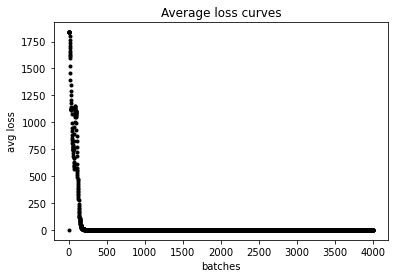

In [17]:
%cd /content/drive/'My Drive'

import matplotlib.pyplot as plt
%matplotlib inline

batch = []
avgloss = []
with open('yolov3_bloodcells_train.log','r') as fobj:
  for line in fobj:
    if len(line.split()) != 14:
      continue
    elif 'avg loss' in line:
      batch.append(line.split()[0].split(':')[0])
      avgloss.append(line.split()[2])

batch = list(map(int, batch))
avgloss = list(map(float, avgloss))

print(batch)
print(avgloss)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(batch, avgloss, '.', color='black')
ax.set_title('Average loss curves')
ax.set_xlabel('batches')
ax.set_ylabel('avg loss')


Step 10. Check mAP.

/content/drive/My Drive
['1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300', '2400', '2500', '2600', '2700', '2800', '2900', '3000', '3100', '3200', '3300', '3400', '3500', '3600', '3700', '3800', '3900', '4000']
[0.604815, 0.754789, 0.795442, 0.703938, 0.881609, 0.915727, 0.908045, 0.941626, 0.797668, 0.937611, 0.87449, 0.949493, 0.955591, 0.959797, 0.958053, 0.971443, 0.973248, 0.952534, 0.928867, 0.870814, 0.977934, 0.967539, 0.98381, 0.98625, 0.986464, 0.985263, 0.984527, 0.985128, 0.984718, 0.985145, 0.984502]


Text(0, 0.5, 'mAP')

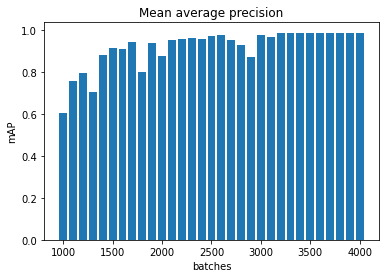

In [18]:
%cd /content/drive/'My Drive'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch = list(range(1000, 4100, 100))
mAP = []
with open('yolov3_bloodcells_train.log','r') as fobj:
  for line in fobj:
    if "mean_average_precision" in line:
      mAP.append(line.split()[3])

batch = list(map(str, batch))
mAP = list(map(float, mAP))

print(batch)
print(mAP)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(batch, mAP)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_title('Mean average precision')
ax.set_xlabel('batches')
ax.set_ylabel('mAP')

Step 11. Test the weights.

In [0]:
%cd /content/drive/'My Drive'
!mkdir predictions
!ln -s /content/drive/'My Drive'/predictions /content/darknet

%cd /content/darknet
import os
import glob
os.system
import PIL
import PIL.Image as Image

#save prediction images
command = "./darknet detector test build/darknet/x64/data/bloodcells.data build/darknet/x64/cfg/yolov3_bloodcells.cfg /content/drive/'My Drive'/backup/yolov3_bloodcells_4000.weights -dont_show"
with open('build/darknet/x64/data/test.txt','r') as fobj:
  for line in fobj:
    image_List = [[num for num in line.split()] for line in fobj]
    for images in image_List:
      name = images[0].split('/')[5].split('.')[0]
      commands = [command, images[0]]
      os.system(' '.join(commands))
      predicted_image = Image.open("predictions.jpg")
      output = 'predictions/' + name + '_prediction.jpg'
      predicted_image.save(output)


/content/drive/My Drive
mkdir: cannot create directory ‘predictions’: File exists
ln: failed to create symbolic link '/content/darknet/predictions': File exists
/content/darknet


Step 12. Show the predicted images.

/content/drive/My Drive/predictions


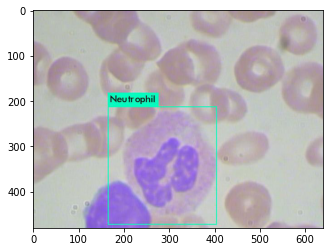

In [0]:
%cd /content/drive/'My Drive'/predictions
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Read image
im = imageio.imread("BloodImage_00313_NL_prediction.jpg")
plt.imshow(im)
